In [38]:
# Import necessary libraries
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Output areas for dynamic display
personal_schedule_output = widgets.Output()
project_schedule_output = widgets.Output()
main_menu_output = widgets.Output()

# File to store tasks for project schedule
TASKS_FILE = "project_tasks.csv"

def show_timetable(time_block_interval, rest_hours, meal_times):
    """
    Generates and displays a daily timetable based on the given parameters.

    Args:
        time_block_interval (str): The time interval for blocks (e.g., '1 hour').
        rest_hours (tuple): A tuple with start and end times for rest (e.g., ('11:00 PM', '7:00 AM')).
        meal_times (dict): A dictionary with meal names as keys and times as values (e.g., {'Breakfast': '8:00 AM'}).
    """
    intervals = {"30 minutes": 0.5, "45 minutes": 0.75, "1 hour": 1, "1.5 hours": 1.5, "2 hours": 2}
    block_hours = intervals[time_block_interval]
    start_hour, end_hour = 7, 23
    num_blocks = int((end_hour - start_hour) / block_hours)

    times = pd.date_range(f"{start_hour}:00", f"{end_hour}:00", freq=f"{int(block_hours * 60)}min").strftime("%I:%M %p")
    timetable_df = pd.DataFrame({"Time": times, "Activity": "Free Time"})

    def get_closest_time_idx(target_time):
        """Finds the closest time index in the timetable for a given target time."""
        if target_time in timetable_df["Time"].values:
            return np.where(timetable_df["Time"] == target_time)[0][0]
        target_time_obj = pd.to_datetime(target_time, format="%I:%M %p")
        time_diffs = abs(pd.to_datetime(timetable_df["Time"], format="%I:%M %p") - target_time_obj)
        return time_diffs.idxmin()

    rest_start_idx = get_closest_time_idx(rest_hours[0])
    rest_end_idx = get_closest_time_idx(rest_hours[1])
    timetable_df.loc[rest_start_idx:rest_end_idx, "Activity"] = "Rest"

    for meal, time in meal_times.items():
        meal_idx = get_closest_time_idx(time)
        timetable_df.loc[meal_idx, "Activity"] = meal

    colors = {"Free Time": "#D3D3D3", "Rest": "#F5DEB3", "Breakfast": "skyblue", "Lunch": "lightgreen", "Dinner": "lightcoral"}
    fig, ax = plt.subplots(figsize=(6, 8))

    for idx, (time, activity) in enumerate(zip(timetable_df["Time"], timetable_df["Activity"])):
        ax.barh(y=time, width=0.8, color=colors.get(activity, "grey"), edgecolor="black", alpha=0.9)
        ax.text(0.4, idx, activity, ha="center", va="center", color="black", fontweight="bold")

    ax.set_title("Daily Timetable", fontdict={'fontsize': 16, 'weight': 'bold'}, pad=15)
    ax.set_yticks(np.arange(len(timetable_df["Time"])))
    ax.set_yticklabels(timetable_df["Time"], fontweight="bold")
    plt.gca().invert_yaxis()
    plt.xticks([])
    plt.tight_layout()
    plt.show()

def personal_schedule():
    """
    Displays the personal schedule module where users can configure their daily schedule.
    """
    with personal_schedule_output:
        clear_output()

        time_block = widgets.Dropdown(
            options=['30 minutes', '45 minutes', '1 hour', '1.5 hours', '2 hours'],
            value='1 hour',
            description='Time Block Interval:',
            style={'description_width': 'initial'}
        )
        rest_start = widgets.Text(value="11:00 PM", description='Rest Start Time:')
        rest_end = widgets.Text(value="7:00 AM", description='Rest End Time:')
        breakfast_time = widgets.Text(value="8:00 AM", description='Breakfast Time:')
        lunch_time = widgets.Text(value="1:00 PM", description='Lunch Time:')
        dinner_time = widgets.Text(value="8:00 PM", description='Dinner Time:')
        confirm_button = widgets.Button(description="Confirm Schedule")
        output = widgets.Output()

        def on_confirm(_):
            with output:
                clear_output()
                show_timetable(time_block.value, (rest_start.value, rest_end.value), {
                    "Breakfast": breakfast_time.value,
                    "Lunch": lunch_time.value,
                    "Dinner": dinner_time.value
                })
                print("Personal Schedule Setup Complete.")

        confirm_button.on_click(on_confirm)
        display(widgets.VBox([
            time_block, rest_start, rest_end,
            breakfast_time, lunch_time, dinner_time,
            confirm_button, output
        ]))

def read_and_visualize_tasks():
    """
    Reads tasks from the project schedule file and visualizes them as a Gantt chart.
    """
    try:
        tasks_data = pd.read_csv(TASKS_FILE)
        tasks_data["Start"] = pd.to_datetime(tasks_data["Start"], format="%Y-%m-%d")
        tasks_data["End"] = tasks_data["Start"] + pd.to_timedelta(tasks_data["Duration"], unit="d")
        tasks_data.sort_values(by="Start", inplace=True)

        def assign_color(row):
            if row["Completed"]:
                return "blue"
            if row["Assigned To"] == "A":
                return "red"
            if row["Assigned To"] == "B":
                return "green"
            if row["Assigned To"] == "C":
                return "violet"
            return "gray"

        tasks_data["Color"] = tasks_data.apply(assign_color, axis=1)
        fig, ax = plt.subplots(figsize=(12, 8))
        for i, row in tasks_data.iterrows():
            ax.barh(row["Task"], (row["End"] - row["Start"]).days, left=row["Start"].toordinal(),
                    color=row["Color"], edgecolor="black", alpha=0.8)
            ax.text(row["Start"].toordinal() + 1, i, f"Assigned To: {row['Assigned To']}",
                    va="center", ha="left", fontsize=9, color="black")

        ax.set_xlabel("Timeline (Dates)")
        ax.set_ylabel("Tasks")
        ax.set_title("Project Schedule Gantt Chart", fontsize=14, fontweight="bold")
        ax.set_yticks(range(len(tasks_data)))
        ax.set_yticklabels(tasks_data["Task"])
        ax.xaxis.set_major_formatter(plt.FuncFormatter(
            lambda x, _: datetime.fromordinal(int(x)).strftime("%Y-%m-%d")))
        plt.tight_layout()
        plt.show()

    except Exception as e:
        with project_schedule_output:
            clear_output()
            print(f"Error visualizing tasks: {e}")

def project_schedule():
    """
    Displays the project schedule module, allowing users to add tasks or view the Gantt chart.
    """
    with project_schedule_output:
        clear_output()

        task_name = widgets.Text(description="Task Name:")
        start_date = widgets.Text(description="Start Date (YYYY-MM-DD):")
        duration = widgets.IntText(description="Duration (days):")
        assigned_to = widgets.Text(description="Assigned To (A, B, C):")
        completed = widgets.Checkbox(description="Completed?")
        add_task_button = widgets.Button(description="Add Task")
        view_chart_button = widgets.Button(description="View Chart")
        output = widgets.Output()

        def write_task_to_file(name, start, duration, assigned_to, completed):
            try:
                existing_data = pd.read_csv(TASKS_FILE) if os.path.exists(TASKS_FILE) else pd.DataFrame(
                    columns=["Task", "Start", "Duration", "Assigned To", "Completed"])
                new_task = pd.DataFrame({
                    "Task": [name],
                    "Start": [start],
                    "Duration": [duration],
                    "Assigned To": [assigned_to],
                    "Completed": [completed]
                })
                updated_data = pd.concat([existing_data, new_task], ignore_index=True)
                updated_data.to_csv(TASKS_FILE, index=False)
                return "Task added successfully!"
            except Exception as e:
                return f"Error writing task: {e}"

        def add_task(_):
            with output:
                clear_output()
                print(write_task_to_file(task_name.value, start_date.value, duration.value, assigned_to.value, completed.value))

        def view_chart(_):
            with output:
                clear_output()
                read_and_visualize_tasks()

        add_task_button.on_click(add_task)
        view_chart_button.on_click(view_chart)
        display(widgets.VBox([
            widgets.Label("Enter Project Tasks"),
            task_name, start_date, duration, assigned_to, completed,
            widgets.HBox([add_task_button, view_chart_button]),
            output
        ]))

def main_menu():
    """
    Displays the main menu for navigation between modules.
    """
    with main_menu_output:
        clear_output()

        schedule_type = widgets.Dropdown(
            options=['Personal Schedule', 'Project Schedule', 'Exit'],
            description='Select Schedule:',
            style={'description_width': 'initial'}
        )
        confirm_button = widgets.Button(description="Confirm")

        def on_confirm(_):
            if schedule_type.value == 'Personal Schedule':
                personal_schedule()
            elif schedule_type.value == 'Project Schedule':
                project_schedule()
            elif schedule_type.value == 'Exit':
                print("Exiting the program. Goodbye!")

        confirm_button.on_click(on_confirm)
        display(widgets.VBox([schedule_type, confirm_button]))

main_menu()
display(main_menu_output)
display(personal_schedule_output)
display(project_schedule_output)

Output()

Output()

Output()

In [44]:
# Import necessary libraries
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd

# Initialize DataFrames to hold events and tasks
weekly_events = pd.DataFrame(columns=["Day", "Time", "Event"])
projects = pd.DataFrame(columns=["Name", "Expected Time (hrs)", "Priority", "Deadline"])

# Global flag to manage timetable visibility
timetable_loaded = False

def update_dropdowns():
    """
    Refresh dropdown options based on current weekly events and projects.
    """
    project_delete_dropdown.options = projects["Name"].tolist() if not projects.empty else ["No projects available"]
    event_delete_dropdown.options = weekly_events["Event"].tolist() if not weekly_events.empty else ["No events available"]

def add_project(b):
    """
    Adds a new project to the projects DataFrame and updates the UI.
    """
    name = project_name.value
    expected_time = project_time.value
    priority = project_priority.value
    deadline = project_deadline.value

    projects.loc[len(projects)] = [name, expected_time, priority, deadline]
    print("\nProject added successfully.")
    update_dropdowns()
    refresh_ui()

def save_to_file():
    """
    Saves weekly events and projects to CSV files.
    """
    weekly_events.to_csv("weekly_events.csv", index=False)
    projects.to_csv("projects.csv", index=False)
    print("Timetable and projects saved to files.")

def load_from_file(b):
    """
    Loads weekly events and projects from CSV files and updates the UI.
    """
    global weekly_events, projects, timetable_loaded
    try:
        weekly_events = pd.read_csv("weekly_events.csv")
        projects = pd.read_csv("projects.csv")
        projects["Deadline"] = pd.to_datetime(projects["Deadline"]).dt.date
        timetable_loaded = True
        update_dropdowns()
        print("Timetable and projects loaded successfully.")
        refresh_ui()
    except FileNotFoundError:
        print("No saved files found. Please save the timetable and projects first.")

def delete_project(b):
    """
    Deletes a selected project and updates the UI.
    """
    project_to_delete = project_delete_dropdown.value
    if project_to_delete != "No projects available":
        global projects
        projects = projects[projects["Name"] != project_to_delete]
        print(f"Project '{project_to_delete}' deleted successfully.")
        update_dropdowns()
        refresh_ui()

def delete_event(b):
    """
    Deletes a selected weekly event and updates the UI.
    """
    event_to_delete = event_delete_dropdown.value
    if event_to_delete != "No events available":
        global weekly_events
        weekly_events = weekly_events[weekly_events["Event"] != event_to_delete]
        print(f"Event '{event_to_delete}' deleted successfully.")
        update_dropdowns()
        refresh_ui()

def add_event_to_weekly_schedule(b):
    """
    Displays a form to add a repeating event to the weekly schedule.
    """
    frequency = widgets.Dropdown(
        options=['Daily', 'Weekly', 'Monthly'],
        value='Daily',
        description='Frequency:',
        style={'description_width': 'initial'}
    )
    event_name = widgets.Text(value='', description='Event Name:')
    event_start_time = widgets.Text(value='9:00 AM', description='Start Time:')
    event_duration = widgets.IntText(value=1, description='Duration (hrs):')
    day_of_week_checkboxes = widgets.SelectMultiple(
        options=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
        value=['Monday'], description='Days of Week:', style={'description_width': 'initial'}
    )
    day_of_month = widgets.IntText(value=1, description='Day of Month:')
    day_of_week_checkboxes.layout.display = 'none'
    day_of_month.layout.display = 'none'

    def update_fields(change):
        day_of_week_checkboxes.layout.display = 'block' if frequency.value == 'Weekly' else 'none'
        day_of_month.layout.display = 'block' if frequency.value == 'Monthly' else 'none'

    frequency.observe(update_fields, names='value')

    add_event_button = widgets.Button(description="Confirm Add Event")
    output = widgets.Output()

    def on_add_event(b):
        with output:
            clear_output()
            weekly_events.loc[len(weekly_events)] = [
                ', '.join(day_of_week_checkboxes.value) if frequency.value == 'Weekly' else None,
                event_start_time.value,
                event_name.value
            ]
            print(f"Event Added: {event_name.value}")
            update_dropdowns()
            refresh_ui()

    add_event_button.on_click(on_add_event)

    display(widgets.VBox([frequency, event_name, event_start_time, event_duration, day_of_week_checkboxes, day_of_month, add_event_button, output]))

def refresh_ui():
    """
    Refreshes the user interface, displaying the updated UI elements and data.
    """
    global show_add_event_form
    clear_output()

    if show_add_event_form:
        add_event_to_weekly_schedule(None)

    display(widgets.VBox([
        widgets.HTML("<h3>Add a New Project</h3>"),
        project_name, project_time, project_priority, project_deadline, add_project_button
    ]))
    display(widgets.HBox([save_button, load_button]))
    display(widgets.VBox([
        widgets.HTML("<h3>Delete a Project</h3>"),
        project_delete_dropdown, delete_project_button
    ]))
    display(widgets.VBox([
        widgets.HTML("<h3>Delete a Weekly Event</h3>"),
        event_delete_dropdown, delete_event_button
    ]))
    display(widgets.VBox([
        widgets.HTML("<h3>Add a New Event</h3>"),
        add_event_button
    ]))

    if timetable_loaded:
        print("\n--- Timetable and Current Data ---")
        print("\nWeekly Repeating Events:")
        print(weekly_events.to_string(index=False))
        print("\nCurrent Projects/Tasks:")
        print(projects.to_string(index=False))

def add_event_button_clicked(b):
    """
    Handles the Add Event button click and displays the event form.
    """
    global show_add_event_form
    show_add_event_form = True
    refresh_ui()

# Create input fields for adding a project
project_name = widgets.Text(description="Name:")
project_time = widgets.IntText(description="Expected Time (hrs):")
project_priority = widgets.Dropdown(options=["Low", "Medium", "High"], description="Priority:")
project_deadline = widgets.DatePicker(description="Deadline:")
add_project_button = widgets.Button(description="Add Project")
add_project_button.on_click(add_project)

# Buttons for saving, loading, and deleting
save_button = widgets.Button(description="Save Timetable & Projects")
load_button = widgets.Button(description="Load Timetable")
delete_project_button = widgets.Button(description="Delete Project")
delete_event_button = widgets.Button(description="Delete Event")

save_button.on_click(lambda b: save_to_file())
load_button.on_click(load_from_file)
delete_project_button.on_click(delete_project)
delete_event_button.on_click(delete_event)

# Dropdowns for deleting projects and events
project_delete_dropdown = widgets.Dropdown(description="Select Project:")
event_delete_dropdown = widgets.Dropdown(description="Select Event:")

# Add Event button
add_event_button = widgets.Button(description="Add Event")
add_event_button.on_click(add_event_button_clicked)

# Initial UI display
show_add_event_form = False
update_dropdowns()
refresh_ui()


--- Timetable and Current Data ---

Weekly Repeating Events:
      Day                Time Event
   Monday  12:00 PM - 1:30 PM   PSP
   Monday   3:15 PM - 5:00 PM   IPR
  Tuesday   2:00 PM - 3:30 PM   IPR
Wednesday 10:30 AM - 12:00 PM   ISA
Wednesday   5:00 PM - 6:30 PM  RARS
 Thursday  12:00 PM - 1:30 PM   PSP
   Friday 10:30 AM - 12:00 PM   ISA
   Friday   5:00 PM - 6:30 PM  RARS

Current Projects/Tasks:
                 Name  Expected Time (hrs) Priority   Deadline
       IPR Assignment                    6     High 2024-11-16
RARS Quiz Preparation                    6     High 2024-11-16


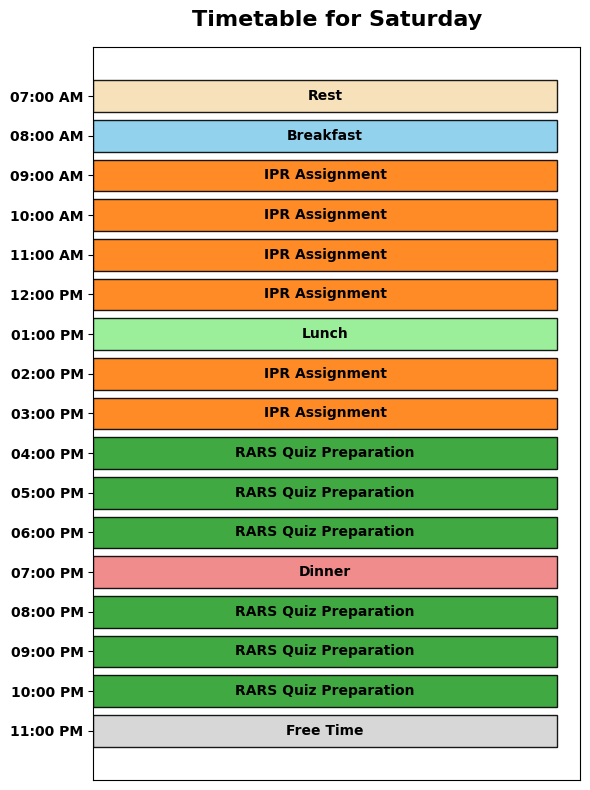

In [45]:
import datetime as dt
import pandas as pd
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

# Constants
TIME_BLOCK_INTERVAL = "1 hour"  # Adjustable: "30 minutes", "45 minutes", etc.
REST_HOURS = ("12:00 AM", "6:00 AM")
MEAL_TIMES = {
    "Breakfast": "08:00 AM",
    "Lunch": "01:00 PM",
    "Dinner": "07:00 PM",
}

# Helper function to find the closest time index
def get_closest_time_idx(timetable_df, target_time):
    target_time_obj = pd.to_datetime(target_time, format="%I:%M %p")
    time_diffs = abs(pd.to_datetime(timetable_df["Time"], format="%I:%M %p") - target_time_obj)
    return time_diffs.idxmin()

# Function to load data and display options
def load_and_display_options():
    try:
        # Load saved files
        weekly_events = pd.read_csv("weekly_events.csv")
        projects = pd.read_csv("projects.csv")
        projects["Deadline"] = pd.to_datetime(projects["Deadline"]).dt.date  # Ensure date format

        print("Timetable loaded successfully! Choose an option below:")
        daily_button = widgets.Button(description="View Daily Timetable")
        weekly_button = widgets.Button(description="View Weekly Timetable")

        daily_button.on_click(lambda b: clear_output() or generate_daily_timetable(weekly_events, projects))
        weekly_button.on_click(lambda b: clear_output() or generate_weekly_timetable(weekly_events, projects))

        display(widgets.HBox([daily_button, weekly_button]))
    except FileNotFoundError:
        print("No saved timetable or projects found. Please ensure files are saved first.")

# Function to generate the daily timetable
def generate_daily_timetable(weekly_events, projects):
    # Setup timetable structure
    today_date = dt.date.today()
    today_day = today_date.strftime("%A")
    intervals = {"30 minutes": 0.5, "45 minutes": 0.75, "1 hour": 1, "1.5 hours": 1.5, "2 hours": 2}
    block_hours = intervals[TIME_BLOCK_INTERVAL]
    times = pd.date_range("07:00 AM", "11:00 PM", freq=f"{int(block_hours * 60)}min").strftime("%I:%M %p")
    timetable_df = pd.DataFrame({"Time": times, "Activity": "Free Time"})

    # Mark rest hours
    rest_start_idx = get_closest_time_idx(timetable_df, REST_HOURS[0])
    rest_end_idx = get_closest_time_idx(timetable_df, REST_HOURS[1])
    timetable_df.loc[rest_start_idx:rest_end_idx, "Activity"] = "Rest"

    # Mark meal times
    for meal, time in MEAL_TIMES.items():
        meal_idx = get_closest_time_idx(timetable_df, time)
        timetable_df.loc[meal_idx, "Activity"] = meal

    # Filter today's events and update timetable
    day_events = weekly_events[weekly_events["Day"] == today_day]
    for _, event in day_events.iterrows():
        event_start_idx = get_closest_time_idx(timetable_df, event["Time"].split(" - ")[0])
        event_end_idx = get_closest_time_idx(timetable_df, event["Time"].split(" - ")[1])
        timetable_df.loc[event_start_idx:event_end_idx, "Activity"] = event["Event"]

    # Assign tasks based on free time
    projects = projects.sort_values(by=["Priority", "Deadline"])  # Sort by priority
    for _, task in projects.iterrows():
        task_name, hours_needed = task["Name"], int(task["Expected Time (hrs)"])
        task_assigned = 0
        for idx, row in timetable_df.iterrows():
            if row["Activity"] == "Free Time" and task_assigned < hours_needed:
                timetable_df.at[idx, "Activity"] = task_name
                task_assigned += 1

    # Plot the timetable
    plot_timetable(timetable_df, today_day)

# Function to generate the weekly timetable
def generate_weekly_timetable(weekly_events, projects):
    today_date = dt.date.today()
    days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

    for day in days_of_week:
        print(f"\n--- {day} ---")
        day_events = weekly_events[weekly_events["Day"] == day]
        if not day_events.empty:
            print("Repeating Events:")
            print(day_events.to_string(index=False))
        else:
            print("No repeating events.")

        day_date = today_date + dt.timedelta(days=(days_of_week.index(day) - today_date.weekday()) % 7)
        tasks_due = projects[projects["Deadline"] == day_date]
        if not tasks_due.empty:
            print("Tasks/Projects Due:")
            print(tasks_due.to_string(index=False))
        else:
            print("No tasks/projects due.")

# Function to plot the timetable
def plot_timetable(timetable_df, today_day):
    colors = {
        "Free Time": "#D3D3D3",
        "Rest": "#F5DEB3",
        "Breakfast": "skyblue",
        "Lunch": "lightgreen",
        "Dinner": "lightcoral",
    }
    unique_activities = timetable_df["Activity"].unique()
    for i, activity in enumerate(unique_activities):
        if activity not in colors:
            colors[activity] = plt.cm.tab20(i)

    fig, ax = plt.subplots(figsize=(6, 8))
    for idx, (time, activity) in enumerate(zip(timetable_df["Time"], timetable_df["Activity"])):
        ax.barh(y=time, width=0.8, color=colors.get(activity, "#D3D3D3"), edgecolor="black", alpha=0.9)
        ax.text(0.4, idx, activity, ha="center", va="center", color="black", fontweight="bold")

    ax.set_title(f"Timetable for {today_day}", fontdict={'fontsize': 16, 'weight': 'bold'}, pad=15)
    ax.set_yticks(range(len(timetable_df["Time"])))
    ax.set_yticklabels(timetable_df["Time"], fontweight="bold")
    plt.gca().invert_yaxis()
    plt.xticks([])
    plt.tight_layout()
    plt.show()

# Initial call to load and display options
load_and_display_options()

In [46]:
from IPython.display import display, clear_output
import ipywidgets as widgets
import pandas as pd
import datetime

# Global variables
current_project_file = None  # Track the active project file
tasks_data = pd.DataFrame()  # Hold loaded tasks

def manage_projects():
    """Creates or loads project files using a graphical user interface."""
    project_name = widgets.Text(description="Project Name:")
    create_project_button = widgets.Button(description="Create Project")
    load_project_button = widgets.Button(description="Load Project")
    project_output = widgets.Output()

    def create_project(b):
        """Handles the creation of a new project file."""
        global current_project_file
        with project_output:
            clear_output()
            if project_name.value.strip():
                current_project_file = f"{project_name.value.strip()}.csv"
                try:
                    # Create an empty CSV file with headers
                    pd.DataFrame(columns=[
                        "Task", "Start", "Duration", "Assigned To", "Priority",
                        "Description", "Dependencies", "Deadline", "Milestone",
                        "Estimated Hours", "Actual Hours", "Comments", "Completed"
                    ]).to_csv(current_project_file, index=False)
                    print(f"New project '{project_name.value}' created successfully!")
                    load_tasks_from_file()
                except Exception as e:
                    print(f"Error creating project: {e}")
            else:
                print("Project name cannot be empty.")

    def load_project(b):
        """Handles loading an existing project file."""
        global current_project_file
        with project_output:
            clear_output()
            if project_name.value.strip():
                current_project_file = f"{project_name.value.strip()}.csv"
                try:
                    pd.read_csv(current_project_file)  # Check if the file exists
                    print(f"Project '{project_name.value}' loaded successfully!")
                    load_tasks_from_file()
                except FileNotFoundError:
                    print(f"Project '{project_name.value}' does not exist. Please create it first.")
                except Exception as e:
                    print(f"Error loading project: {e}")
            else:
                print("Project name cannot be empty.")

    display(widgets.VBox([
        widgets.Label("Manage Projects"),
        project_name,
        widgets.HBox([create_project_button, load_project_button]),
        project_output
    ]))

    create_project_button.on_click(create_project)
    load_project_button.on_click(load_project)

def load_tasks_from_file():
    """Loads tasks from the active project file."""
    global tasks_data
    if current_project_file:
        try:
            tasks_data = pd.read_csv(current_project_file)
            update_task_dropdown()
            update_progress_bar()
        except FileNotFoundError:
            tasks_data = pd.DataFrame()
    else:
        tasks_data = pd.DataFrame()

def update_task_dropdown():
    """Updates the dropdown menu with task names."""
    options = ["Add New Task"] + (tasks_data['Task'].dropna().tolist() if not tasks_data.empty else [])
    task_dropdown.options = options
    if task_dropdown.value not in options:
        task_dropdown.value = "Add New Task"  # Reset dropdown to a valid default

def on_task_select(change):
    """Handles task selection changes."""
    if task_dropdown.value == "Add New Task":
        clear_task_fields()
    elif task_dropdown.value and not tasks_data.empty:
        selected_task = tasks_data[tasks_data['Task'] == task_dropdown.value].iloc[0]
        autofill_task_details(selected_task)

def autofill_task_details(task_details):
    """Autofills fields based on the selected task."""
    task_name_input.value = task_details['Task']
    start_date_input.value = pd.to_datetime(task_details['Start']).date()
    duration_input.value = int(task_details['Duration']) if 'Duration' in task_details else 1
    assigned_to_input.value = task_details['Assigned To']
    task_priority_input.value = task_details.get('Priority', 'Medium')
    task_description_input.value = task_details.get('Description', '')
    task_dependency_input.value = task_details.get('Dependencies', '').split(', ') if 'Dependencies' in task_details else []
    task_deadline_input.value = calculate_deadline(task_details)
    milestone_input.value = bool(task_details.get('Milestone', False))
    estimated_hours_input.value = int(task_details.get('Estimated Hours', 0))
    actual_hours_input.value = int(task_details.get('Actual Hours', 0))
    task_comments_input.value = task_details.get('Comments', '')

def calculate_deadline(task_details):
    """Calculates the task deadline by adding duration to the start date."""
    try:
        start_date = pd.to_datetime(task_details['Start']).date()
        duration = int(task_details['Duration']) if 'Duration' in task_details else 1
        deadline = start_date + datetime.timedelta(days=duration)
        return deadline
    except Exception as e:
        print(f"Error calculating deadline: {e}")
        return datetime.date.today()

def clear_task_fields():
    """Clears input fields for creating a new task."""
    task_name_input.value = ""
    start_date_input.value = datetime.date.today()
    duration_input.value = 1
    assigned_to_input.value = "A"
    task_priority_input.value = "Medium"
    task_description_input.value = ""
    task_dependency_input.value = []
    task_deadline_input.value = datetime.date.today()
    milestone_input.value = False
    estimated_hours_input.value = 0
    actual_hours_input.value = 0
    task_comments_input.value = ""

def save_task_data(b):
    """Saves task data to the project file."""
    global tasks_data

    task_name = task_name_input.value.strip()
    if not task_name:
        print("Task name cannot be empty!")
        return

    task_data = {
        "Task": task_name,
        "Start": start_date_input.value,
        "Duration": duration_input.value,
        "Assigned To": assigned_to_input.value,
        "Priority": task_priority_input.value,
        "Description": task_description_input.value,
        "Dependencies": ', '.join(task_dependency_input.value),
        "Deadline": task_deadline_input.value,
        "Milestone": milestone_input.value,
        "Estimated Hours": estimated_hours_input.value,
        "Actual Hours": actual_hours_input.value,
        "Comments": task_comments_input.value,
        "Completed": False
    }

    if task_name in tasks_data['Task'].tolist():
        tasks_data.loc[tasks_data['Task'] == task_name] = task_data
    else:
        tasks_data = pd.concat([tasks_data, pd.DataFrame([task_data])], ignore_index=True)

    tasks_data.to_csv(current_project_file, index=False)
    load_tasks_from_file()
    print(f"Task '{task_name}' saved successfully!")

def update_progress_bar():
    """Updates the progress bar based on task completion."""
    if tasks_data.empty:
        progress_bar.value = 0
        return

    total_tasks = len(tasks_data)
    completed_tasks = len(tasks_data[tasks_data['Completed'] == True])
    completion_percentage = (completed_tasks / total_tasks) * 100 if total_tasks > 0 else 0
    progress_bar.value = completion_percentage

# Task management widgets
task_dropdown = widgets.Dropdown(description="Task Name:", options=["Add New Task"])
task_dropdown.observe(on_task_select, names='value')

task_name_input = widgets.Text(description="Task Name:")
start_date_input = widgets.DatePicker(description="Start Date:", value=datetime.date.today())
duration_input = widgets.IntText(description="Duration (days):", value=1)
assigned_to_input = widgets.Dropdown(description="Assigned To:", options=["A", "B", "C"], value="A")
task_priority_input = widgets.Dropdown(description="Priority:", options=["Low", "Medium", "High"], value="Medium")
task_description_input = widgets.Textarea(description="Description:", layout=widgets.Layout(width='300px'))
task_dependency_input = widgets.SelectMultiple(description="Dependencies:", options=[])
task_deadline_input = widgets.DatePicker(description="Deadline:", value=datetime.date.today())
milestone_input = widgets.Checkbox(description="Milestone", value=False)
estimated_hours_input = widgets.IntText(description="Estimated Hours:", value=1)
actual_hours_input = widgets.IntText(description="Actual Hours:", value=0)
task_comments_input = widgets.Textarea(description="Comments:", layout=widgets.Layout(width='300px', height='100px'))

save_button = widgets.Button(description="Save Task")
save_button.on_click(save_task_data)

# Progress bar widget
progress_bar = widgets.FloatProgress(
    value=0,
    min=0,
    max=100,
    step=1,
    description="Completion:",
    style={'description_width': 'initial'}
)

# Display interface
manage_projects()
display(
    widgets.VBox([
        widgets.Label("Task Management"),
        task_dropdown, task_name_input, start_date_input, duration_input,
        assigned_to_input, task_priority_input, task_description_input,
        task_dependency_input, task_deadline_input, milestone_input,
        estimated_hours_input, actual_hours_input, task_comments_input,
        save_button, progress_bar
    ])
)

In [48]:
!apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (364 kB/s)
Selecting previously unselected package tree.
(Reading database ... 123629 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [50]:
import os

# Create src directory within the project structure
os.makedirs('Personalized-Scheduler-and-Project-Management/src', exist_ok=True)

# Move all CSV files into the src folder
!mv *.csv Personalized-Scheduler-and-Project-Management/src/ 2>/dev/null

# Check the directory structure using os.walk instead of tree
for root, dirs, files in os.walk('Personalized-Scheduler-and-Project-Management'):
    level = root.replace('Personalized-Scheduler-and-Project-Management', '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")

Personalized-Scheduler-and-Project-Management/
    src/
        weekly_events.csv
        projects_tasks.csv
        projects.csv


In [51]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [52]:
!git config --global user.name "AasthaMariamJohn"
!git config --global user.email "aastha_b200956ec@nitc.ac.in"

In [53]:
%cd Personalized-Scheduler-and-Project-Management
!git init

/content/Personalized-Scheduler-and-Project-Management
hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/Personalized-Scheduler-and-Project-Management/.git/


In [54]:
!git remote add origin https://github.com/AasthaMariamJohn/Personalized-Scheduler-and-Project-Management.git

In [55]:
!git add .
!git commit -m "Initial commit with notebook and CSV files"
!git branch -M main  # Rename branch to main, if needed
!git push origin main

[master (root-commit) 919ffff] Initial commit with notebook and CSV files
 3 files changed, 21 insertions(+)
 create mode 100644 src/projects.csv
 create mode 100644 src/projects_tasks.csv
 create mode 100644 src/weekly_events.csv
fatal: could not read Username for 'https://github.com': No such device or address
